# Import Libraries

In [108]:
import sys
sys.path.append("../src/")

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

In [109]:
# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [110]:
import matplotlib.pyplot as plt

In [111]:
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix

# Load Data

In [112]:
df_feats = pd.read_parquet("../features/sleep-edf_cassette_clip_features_ALL_90s.parquet")

# Preprocessing

## Applied Frequency bands

In [113]:
eeg_signals = ['EEG Fpz-Cz', 'EEG Pz-Oz']
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")

In [114]:
file_list = [psg_file for psg_file in df_feats.psg_file.unique()]
tester = df_feats[df_feats.psg_file == file_list[0]]
print(file_list[0])

SC40010E0-PSG.edf


In [115]:
to_plot = tester.filter(regex=("__theta__|__alpha__"))

In [144]:
to_plot

,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__theta__w=1m,EEG Fpz-Cz__theta__w=1m30s,EEG Fpz-Cz__theta__w=30s,EEG Pz-Oz__alpha__w=1m,EEG Pz-Oz__alpha__w=1m30s,EEG Pz-Oz__alpha__w=30s,EEG Pz-Oz__theta__w=1m,EEG Pz-Oz__theta__w=1m30s,EEG Pz-Oz__theta__w=30s,EOG horizontal__alpha__w=1m,EOG horizontal__alpha__w=1m30s,EOG horizontal__alpha__w=30s,EOG horizontal__theta__w=1m,EOG horizontal__theta__w=1m30s,EOG horizontal__theta__w=30s
index,,,,,,,,,,,,,,,,,,
1989-04-25 00:33:30,0.015259,0.018803,0.012757,0.097024,0.094023,0.089515,0.117308,0.110927,0.114287,0.117710,0.120065,0.117468,0.006643,0.007832,0.007273,0.041156,0.044346,0.036866
1989-04-25 00:34:00,0.020921,0.020288,0.017691,0.091992,0.086977,0.099147,0.104304,0.117180,0.120842,0.125913,0.139925,0.117519,0.008028,0.006746,0.006770,0.054029,0.045725,0.056664
1989-04-25 00:34:30,0.021050,0.019639,0.023591,0.086905,0.082306,0.102372,0.117645,0.110626,0.100521,0.146872,0.136836,0.132304,0.008146,0.006489,0.010461,0.047902,0.040309,0.044891
1989-04-25 00:35:00,0.017155,0.018443,0.018922,0.079696,0.078315,0.080263,0.117364,0.111164,0.153343,0.137386,0.135522,0.150549,0.005333,0.005938,0.005759,0.034560,0.034584,0.038226
1989-04-25 00:35:30,0.017314,0.015340,0.013101,0.078421,0.082192,0.067998,0.097857,0.109662,0.083009,0.127009,0.126307,0.101628,0.006100,0.006501,0.004411,0.034590,0.032793,0.031553
1989-04-25 00:36:00,0.014802,0.014384,0.022376,0.082622,0.088143,0.090617,0.112950,0.108551,0.093126,0.128668,0.131418,0.127531,0.008113,0.008139,0.008317,0.033384,0.034412,0.038958
1989-04-25 00:36:30,0.012095,0.011745,0.010444,0.081562,0.089250,0.085266,0.112799,0.106377,0.135837,0.131099,0.126869,0.141813,0.007926,0.006547,0.007185,0.031033,0.031828,0.027976
1989-04-25 00:37:00,0.012050,0.012503,0.010256,0.083997,0.068717,0.078204,0.093875,0.099168,0.090582,0.125109,0.108549,0.125004,0.006524,0.008282,0.011494,0.033599,0.038253,0.041493
1989-04-25 00:37:30,0.013699,0.025990,0.012934,0.071945,0.079030,0.086274,0.094729,0.185545,0.097610,0.088512,0.100717,0.132514,0.007544,0.005879,0.004101,0.037600,0.028336,0.032122


In [116]:
to_plot.columns

Index(['EEG Fpz-Cz__alpha__w=1m', 'EEG Fpz-Cz__alpha__w=1m30s',
       'EEG Fpz-Cz__alpha__w=30s', 'EEG Fpz-Cz__theta__w=1m',
       'EEG Fpz-Cz__theta__w=1m30s', 'EEG Fpz-Cz__theta__w=30s',
       'EEG Pz-Oz__alpha__w=1m', 'EEG Pz-Oz__alpha__w=1m30s',
       'EEG Pz-Oz__alpha__w=30s', 'EEG Pz-Oz__theta__w=1m',
       'EEG Pz-Oz__theta__w=1m30s', 'EEG Pz-Oz__theta__w=30s',
       'EOG horizontal__alpha__w=1m', 'EOG horizontal__alpha__w=1m30s',
       'EOG horizontal__alpha__w=30s', 'EOG horizontal__theta__w=1m',
       'EOG horizontal__theta__w=1m30s', 'EOG horizontal__theta__w=30s'],
      dtype='object')

In [142]:
tester.shape

(37, 396)

In [139]:
to_plot.shape

(37, 18)

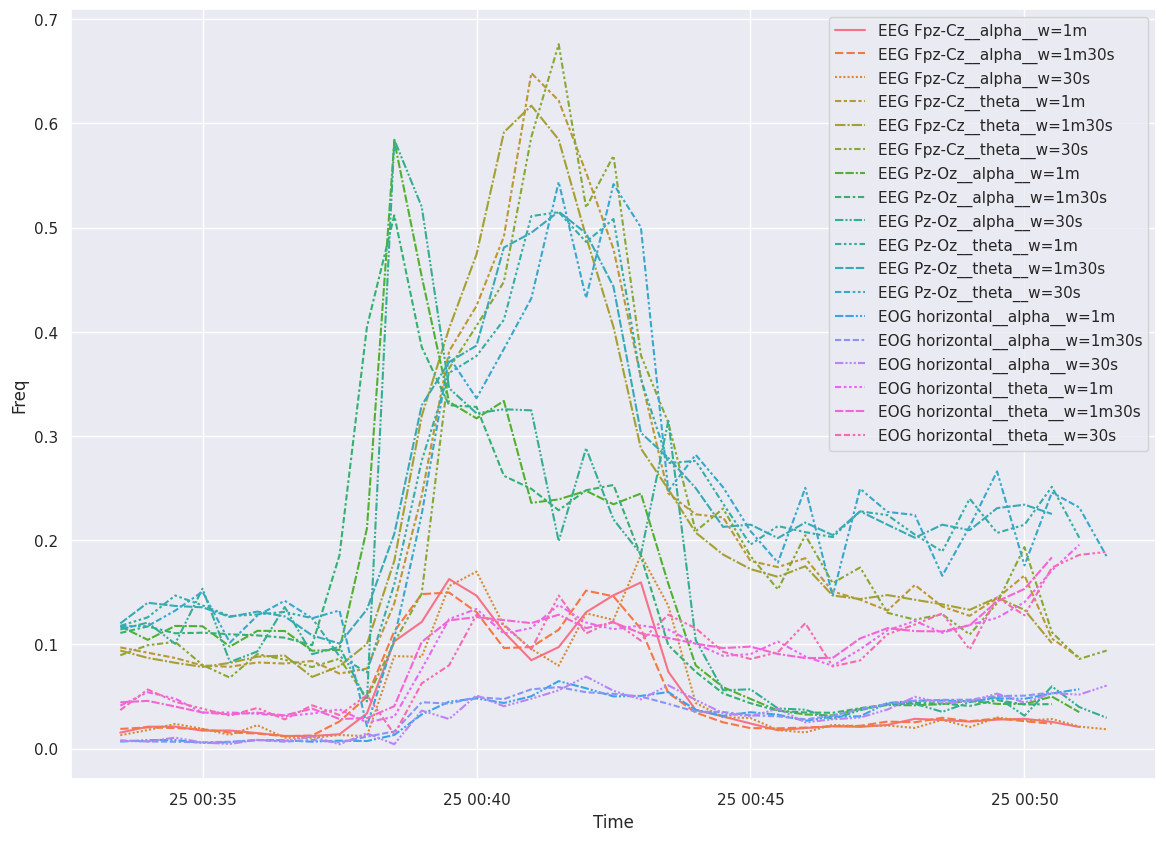

In [143]:
import seaborn as sns
import matplotlib.ticker as ticker
# sns.set_style('dark')
sns.set(rc={'figure.figsize':(14,10)})
sns.color_palette("Paired")


# ax = sns.lineplot(data=to_plot.iloc[5:24])
ax = sns.lineplot(data=to_plot)


# ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Freq')
plt.xlabel('Time')
plt.show()

## Add Different Time Window's Features

In [7]:
skip_cols = ["psg_file", "label", "patient_id", "file_id", "clip_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if (("w=30s" in f) and ("w=1m30s" not in f))]
feats_60s = [f for f in df_feats.columns if (("w=1m" in f) and ("w=1m30s" not in f))]
feats_90s = [f for f in df_feats.columns if ("w=1m30s" in f)]
# print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)

## Postprocess the Label

In [8]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

In [9]:
df_feats = df_feats[~df_feats["label"].isna()]

In [10]:
df_feats.shape

(91487, 1051)

In [11]:
no_shift_cols = [c for c in df_feats.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)
normal_nan_mask = (df_feats[no_shift_cols].isna().sum() / df_feats.psg_file.nunique()).isin([0, 1, 2])
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EEG Pz-Oz__delta/theta__w=1m                                    3297
EEG Pz-Oz__fourier_entropy_{'bins': 3}__w=1m                    3297
EEG Pz-Oz__beta__w=1m                                           3297
EEG Pz-Oz__binned_entropy_{'max_bins': 10}__w=1m                3297
EEG Pz-Oz__binned_entropy_{'max_bins': 30}__w=1m                3297
                                                                ... 
EOG horizontal__binned_entropy_{'max_bins': 30}__w=1m           3297
EOG horizontal__binned_entropy_{'max_bins': 5}__w=1m            3297
EEG Fpz-Cz__TotalAbsPow__w=1m                                   3297
EMG submental__fft_aggregated_{'aggtype': 'skew'}__w=30s          16
EMG submental__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s      16
Length: 133, dtype: int64

In [12]:
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats)

0.03621279526052882

## Plot the Number of Labels

<AxesSubplot:>

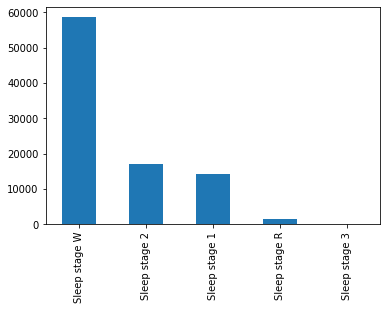

In [13]:
df_feats["label"].value_counts().plot(kind="bar")

In [14]:
df_feats["label"].value_counts()

Sleep stage W    58574
Sleep stage 2    17117
Sleep stage 1    14290
Sleep stage R     1504
Sleep stage 3        2
Name: label, dtype: int64

In [15]:
df_feats = df_feats[df_feats["label"] != "Sleep stage 3"]
df_feats["label"].value_counts()

Sleep stage W    58574
Sleep stage 2    17117
Sleep stage 1    14290
Sleep stage R     1504
Name: label, dtype: int64

# Linear Model

In [16]:
skip_cols = ["psg_file", "label", "patient_id", "file_id", "clip_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [19]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model", SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

In [20]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=10)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=25,
    return_train_score=True,
    return_estimator=True,
)

In [22]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.7721
  Balanced accuracy:  0.8289
  Accuracy:           0.8749
  Log loss:           0.4545


In [23]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

10-FOLD: TEST
  MACRO F1:           0.7322
  Balanced accuracy:  0.7882
  Accuracy:           0.8571
  Log loss:           0.5897


In [24]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [25]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7339558809932166
ACC: 0.8571787724763622
KAPPA: 0.7361854858206434
LOG LOSS: 0.5893129993059887


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

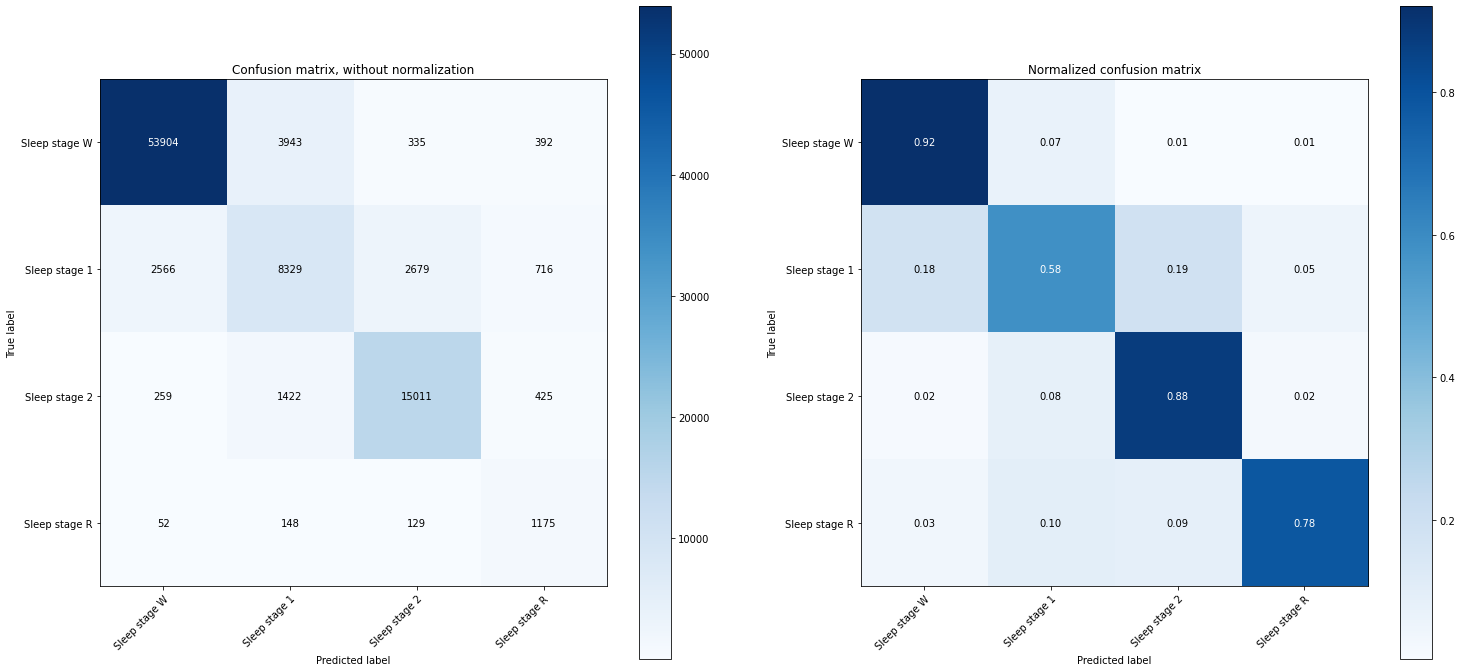

In [26]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

In [ ]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

# Save the Estimators

In [27]:
import joblib
# 將 res 物件儲存為檔案
joblib.dump(res, "../models/res.pkl")

['../models/res.pkl']